In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import numpy as np
import matplotlib.pyplot as plt
import multielec_src.fitting as fitting
import multielec_src.multielec_utils as mutils
from scipy.io import loadmat
import multiprocessing as mp
import statsmodels.api as sm
from copy import deepcopy, copy
import visionloader as vl

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def sample_spikes(p_true, t):
    p_true, t = np.array(p_true), np.array(t).astype(int)
    
    p_empirical = []
    for i in range(len(p_true)):
        if t[i] == 0:
            p_empirical += [0.5]
        
        else:
            p_empirical += [np.mean(np.random.choice(np.array([0, 1]), 
                                                 p=np.array([1-p_true[i], p_true[i]]), 
                                                 size=t[i]))]
        
    p_empirical_array = np.array(p_empirical)

    return p_empirical_array

In [3]:
def sample_spikes_array(true_probs, trials, NUM_THREADS=24):

    input_list = []
    for i in range(len(true_probs)):
        for j in range(len(true_probs[i])):
            input_list += [(true_probs[i][j], trials[j])]
            
    pool = mp.Pool(processes=NUM_THREADS)
    results = pool.starmap_async(sample_spikes, input_list)
    mp_output = results.get()
    pool.close()

    return np.array(mp_output).reshape(true_probs.shape)
    

In [4]:
def get_performance_array(true_params, curr_probs, true_probs):
    
    error = 0
    cnt = 0
    for i in range(len(true_params)):
        for j in range(len(true_params[i])):
            if ~np.all(true_params[i][j][:, 0] == -np.inf):
                error += np.sqrt(np.sum((curr_probs[i][j] - true_probs[i][j])**2) / len(true_probs[i][j]))
                cnt += 1

    return error / cnt

In [5]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2023-03-10-0"
wnoise = "data000"
# blanked_probs = 12

estim_neg = "data001"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_neg = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_neg = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_neg = np.array([mutils.get_stim_amps_newlv(electrical_path, 1).reshape(-1, 1)] * len(trials_neg))

# all_probs_neg[:, :, :blanked_probs] = np.zeros(all_probs_neg[:, :, :blanked_probs].shape)

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        all_probs_neg[i][j] = fitting.disambiguate_sigmoid(all_probs_neg[i][j], spont_limit=0.3, noise_limit=0.1)
        
all_probs_neg = all_probs_neg[:, :, ::-1]
trials_neg = trials_neg[:, ::-1]
amps_neg = amps_neg[:, ::-1, :]

In [6]:
ms = [1]

w_inits_array = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
for i in range(len(w_inits_array)):
    for j in range(len(w_inits_array[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps_neg[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array[i][j] = w_inits

In [7]:
input_list = fitting.generate_input_list(all_probs_neg, amps_neg, trials_neg, w_inits_array)

pool = mp.Pool(processes=24)
results = pool.starmap_async(fitting.fit_surface, input_list)
mp_output = results.get()
pool.close()

In [8]:
params_true = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
inits = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
R2s = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]))
probs_true = np.zeros(all_probs_neg.shape)

cnt = 0
for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        params_true[i][j] = mp_output[cnt][0]
        inits[i][j] = mp_output[cnt][1]
        R2s[i][j] = mp_output[cnt][2]
        
        probs_true[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps_neg[j], has_constant='add'), 
                                params_true[i][j])
        

        cnt += 1

[[-4.59511985 -1.76511731]] -0.6872990318759244


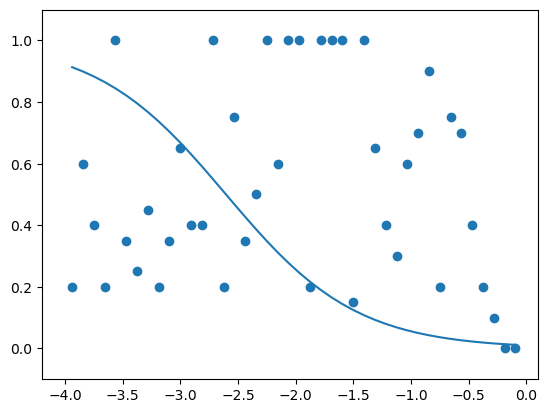

[[-6.81267658 -4.6442809 ]] 0.7258305252283429


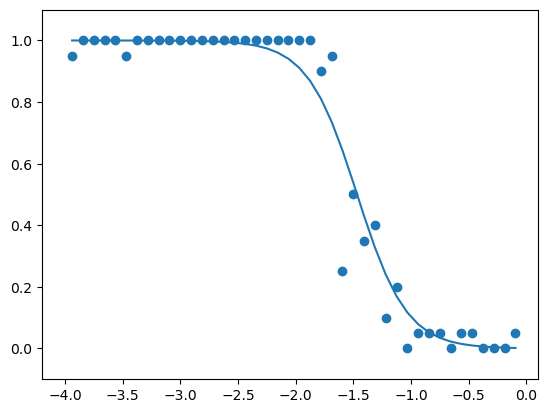

[[-5.44715689 -3.21266795]] 0.6224549207580765


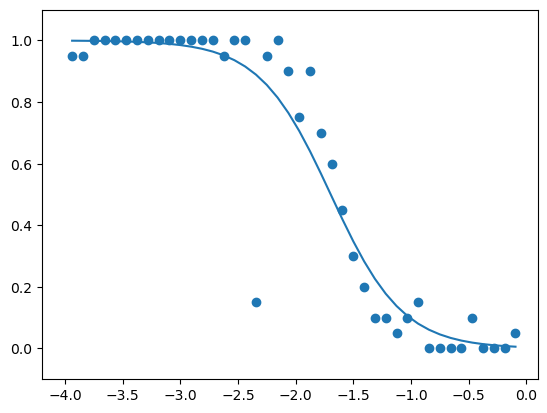

[[-8.88731337 -7.15471956]] 0.8098786289586224


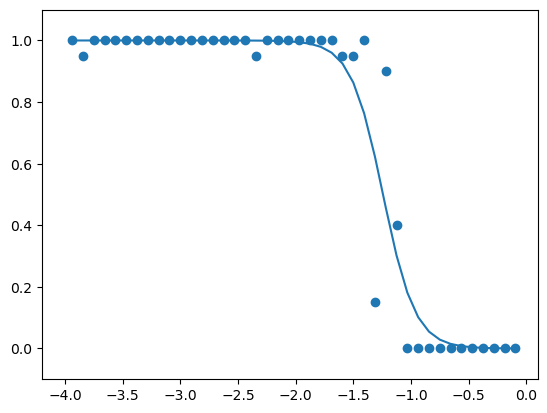

[[-14.72988853  -8.09890778]] 0.8500815530127924


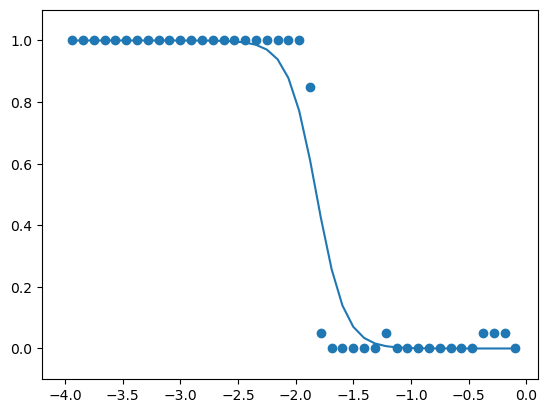

[[-21.55647818  -9.7019311 ]] 0.8747630827776178


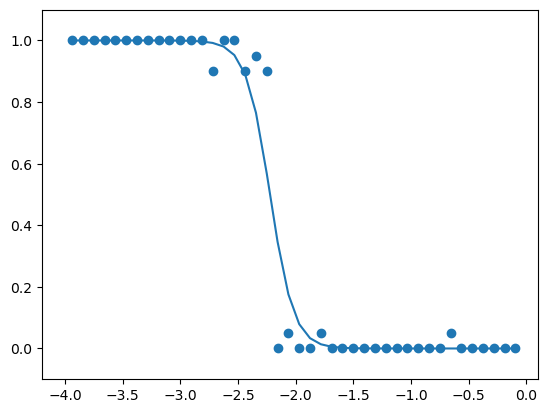

[[-9.00644547 -5.84014914]] 0.7846360533570864


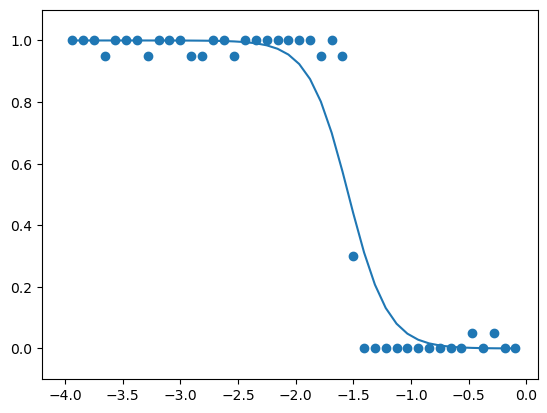

[[-12.56630519  -7.32462511]] 0.8326203593932283


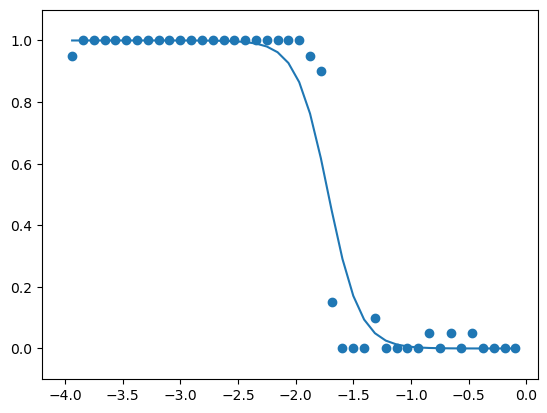

[[-11.21494503  -6.01136934]] 0.798652637559944


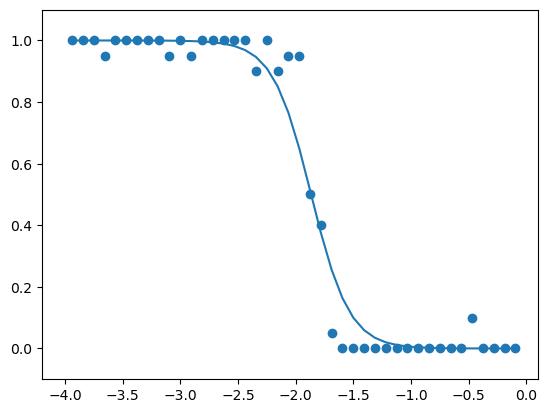

[[-14.80341204  -4.80258573]] 0.6852969812131798


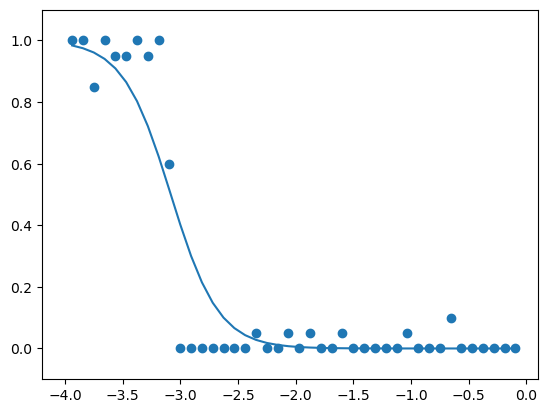

[[-5.34910784 -1.08347177]] 0.13758568171845453


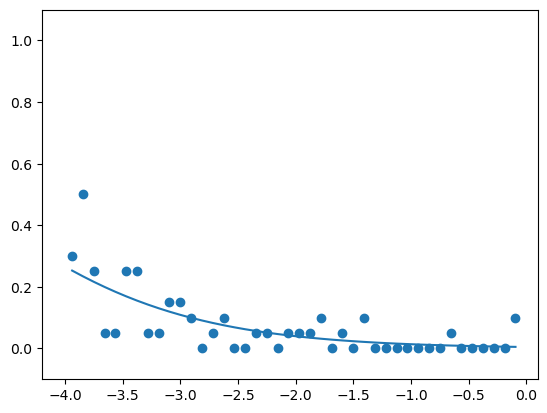

KeyboardInterrupt: Interrupted by user

In [9]:
# CHECK DATASET IF NEEDED

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            print(params_true[i][j], R2s[i][j])
            
            plt.figure(0)
            plt.xlim(-4.2, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps_neg[j].flatten(), all_probs_neg[i][j])
            plt.plot(amps_neg[j].flatten(), probs_true[i][j])
            plt.show()
            input()

In [ ]:
EI_cutoff = 0

vstim_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vstim_datarun = wnoise[-7:]
vcd = vl.load_vision_data(vstim_datapath, vstim_datarun,
                          include_neurons=True,
                          include_ei=True,
                          include_params=True,
                          include_noise=True)

above_thr_inds = []
for n in vcd.get_cell_ids():
    cell_type = vcd.get_cell_type_for_cell(n).lower()
    if 'on' in cell_type or 'off' in cell_type:
        _, EI = mutils.get_collapsed_ei_thr(vcd, n, 0)
        above_thr = np.where(EI > EI_cutoff)[0]
        if len(above_thr) > 0:
            above_thr_inds.append(above_thr)

above_thr_all = np.unique(np.concatenate(above_thr_inds))
bad_inds = np.setdiff1d(np.arange(len(trials_neg), dtype=int), above_thr_all).astype(int)

In [ ]:
total_budget = 20000
num_iters = 2
budget = 512*42*2 #int(total_budget / num_iters)
reg = None # 20, 50
T_step_size = 0.1 # 0.05, 0.01
T_n_steps = 1000    # 5000
init_trials = 5
ms = [1]
disambiguate = True
verbose = True
R2_cutoff = 0

T_prev = np.zeros_like(trials_neg, dtype=float)
T_prev[:, ::3] = init_trials
# T_prev[bad_inds, :] = 0
T_prev_uniform = deepcopy(T_prev)

probs_empirical = sample_spikes_array(probs_true, T_prev, NUM_THREADS=24)
probs_empirical_uniform = deepcopy(probs_empirical)

performances = []
performances_uniform = []
num_samples = []
num_samples_uniform = []

iter_cnt = 0
while True:
    if iter_cnt == 0:
        T_new, w_inits_array, t_final, probs_curr = fitting.fisher_sampling_1elec(probs_empirical, 
                                        T_prev, amps_neg,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff)

        performance = get_performance_array(params_true, probs_curr, probs_true)
        performance_uniform = performance

        w_inits_array_uniform = deepcopy(w_inits_array)
        
    else:
        T_new, w_inits_array, t_final, probs_curr = fitting.fisher_sampling_1elec(probs_empirical, 
                                        T_prev, amps_neg,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        t_final=t_final,
                                        w_inits_array=w_inits_array,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff)
        
        performance = get_performance_array(params_true, probs_curr, probs_true)

        input_list_uniform = fitting.generate_input_list(probs_empirical_uniform, amps_neg, T_prev_uniform, w_inits_array_uniform,
                                                            disambiguate=disambiguate)

        pool = mp.Pool(processes=24)
        results_uniform = pool.starmap_async(fitting.fit_surface, input_list_uniform)
        mp_output_uniform = results_uniform.get()
        pool.close()

        params_curr_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        w_inits_array_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        probs_curr_uniform = np.zeros(probs_empirical_uniform.shape)

        cnt = 0
        for i in range(len(probs_empirical_uniform)):
            for j in range(len(probs_empirical_uniform[i])):
                params_curr_uniform[i][j] = mp_output_uniform[cnt][0]
                w_inits_array_uniform[i][j] = mp_output_uniform[cnt][1]
                
                probs_curr_uniform[i][j] = fitting.sigmoidND_nonlinear(
                                        sm.add_constant(amps_neg[j], has_constant='add'), 
                                        params_curr_uniform[i][j])

                cnt += 1

        performance_uniform = get_performance_array(params_true, probs_curr_uniform, probs_true)
    
    print(performance, performance_uniform)
    
    performances.append(performance)
    performances_uniform.append(performance_uniform)
    
    num_samples.append(np.sum(T_prev))
    num_samples_uniform.append(np.sum(T_prev_uniform))

    iter_cnt += 1

    if iter_cnt > num_iters:
        break

    p_new = sample_spikes_array(probs_true, T_new, NUM_THREADS=24)
    p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
    T_tmp = T_new + T_prev

    p_tmp = np.nan_to_num(p_tmp, nan=0.5)

    probs_empirical = p_tmp
    T_prev = T_tmp
    
    T_new_uniform = np.ones_like(T_prev_uniform, dtype=float)
    # T_new_uniform[:, :12] = 0
    # T_new_uniform[bad_inds, :] = 0
    p_new_uniform = sample_spikes_array(probs_true, T_new_uniform, NUM_THREADS=24)

    p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])
    T_tmp_uniform = T_prev_uniform + T_new_uniform

    p_tmp_uniform = np.nan_to_num(p_tmp_uniform, nan=0.5)

    probs_empirical_uniform = p_tmp_uniform
    T_prev_uniform = T_tmp_uniform

In [ ]:
baseline_trials = 20
T_prev_baseline = np.ones_like(trials_neg, dtype=float) * baseline_trials

probs_empirical_baseline = sample_spikes_array(probs_true, T_prev_baseline, NUM_THREADS=24)

w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
for i in range(len(w_inits_array_baseline)):
    for j in range(len(w_inits_array_baseline[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps_neg[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array_baseline[i][j] = w_inits

input_list_baseline = fitting.generate_input_list(probs_empirical_baseline, amps_neg, T_prev_baseline, w_inits_array_baseline,
                                                    disambiguate=disambiguate)

pool = mp.Pool(processes=24)
results_baseline = pool.starmap_async(fitting.fit_surface, input_list_baseline)
mp_output_baseline = results_baseline.get()
pool.close()

params_curr_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
probs_curr_baseline = np.zeros(probs_empirical_baseline.shape)

cnt = 0
for i in range(len(probs_empirical_baseline)):
    for j in range(len(probs_empirical_baseline[i])):
        params_curr_baseline[i][j] = mp_output_baseline[cnt][0]
        w_inits_array_baseline[i][j] = mp_output_baseline[cnt][1]
        
        probs_curr_baseline[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps_neg[j], has_constant='add'), 
                                params_curr_baseline[i][j])

        cnt += 1

performance_baseline = get_performance_array(params_true, probs_curr_baseline, probs_true)

In [ ]:
plt.figure(figsize=(10, 8))

plt.plot(np.array(num_samples)/trials_neg.shape[0]/trials_neg.shape[1], performances, linewidth=4, c='tab:blue', label='Active Learning')
plt.plot(np.array(num_samples_uniform)/trials_neg.shape[0]/trials_neg.shape[1], performances_uniform, linewidth=4, c='tab:red', label='Uniform Sampling')

plt.axhline(performance_baseline, c='k', linestyle='--', linewidth=2, label='20 Uniform Trials')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Average Trials per Current Level', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)

In [ ]:
# CHECK DATASET IF NEEDED

for i in range(len(probs_true)):
    for j in range(len(probs_true[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            sampled_inds = np.where(T_prev[j] > 0)[0]

            print(params_true[i][j])
            
            plt.figure(0)
            plt.xlim(-4.4, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps_neg[j][sampled_inds], probs_empirical[i][j][sampled_inds])
            plt.plot(amps_neg[j], probs_curr[i][j])
            plt.plot(amps_neg[j], probs_true[i][j])
            plt.show()
            input()

In [ ]:
# CHECK DATASET IF NEEDED

for i in range(len(probs_true)):
    for j in range(len(probs_true[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            sampled_inds_uniform = np.where(T_prev_uniform[j] > 0)[0]

            print(params_true[i][j])
            
            plt.figure(0)
            plt.xlim(-4.4, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps_neg[j][sampled_inds_uniform], probs_empirical_uniform[i][j][sampled_inds_uniform])
            plt.plot(amps_neg[j], probs_curr_uniform[i][j])
            plt.plot(amps_neg[j], probs_true[i][j])
            plt.show()
            input()

# New labview

In [ ]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2022-11-28-1"
wnoise = "data010"
prob_high = 1
prob_low = 0.2
min_inds = 2

estim_neg = "data009"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_neg = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_neg = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_neg = np.array([mutils.get_stim_amps_newlv(electrical_path, 1).reshape(-1, 1)] * len(trials_neg))

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        if np.count_nonzero((all_probs_neg[i][j] >= prob_low) & (all_probs_neg[i][j] <= prob_high)) >= min_inds:
            print(cells[i], j+1)

            # all_probs[i][j] = fitting.disambiguate_fitting(amps[j], 
            #                                 all_probs[i][j],
            #                                 trials[j], [1], 
            #                                 prob_high=prob_high, prob_low=prob_low)

            all_probs_neg[i][j] = fitting.disambiguate_sigmoid(all_probs_neg[i][j], spont_limit=prob_low, noise_limit=0.1)
        
all_probs_neg = all_probs_neg[:, :, ::-1]
trials_neg = trials_neg[:, ::-1]
amps_neg = amps_neg[:, ::-1, :]

In [ ]:
all_probs_neg.shape

In [ ]:
estim_pos = "data003"

outpath = os.path.join(GSORT_BASE, dataset, estim_pos, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_pos)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_pos = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_pos = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_pos = np.array([mutils.get_stim_amps_newlv(electrical_path, 1).reshape(-1, 1)] * len(trials_pos))

# all_probs_pos[:, :, :blanked_probs] = np.zeros(all_probs_pos[:, :, :blanked_probs].shape)

for i in range(len(all_probs_pos)):
    for j in range(len(all_probs_pos[i])):
        all_probs_pos[i][j] = fitting.disambiguate_sigmoid(all_probs_pos[i][j], spont_limit=0.3, noise_limit=0.1)

In [ ]:
all_probs = all_probs_neg#np.concatenate((all_probs_neg, all_probs_pos), axis=2)
trials = trials_neg#np.concatenate((trials_neg, trials_pos), axis=1)
amps = amps_neg#np.concatenate((amps_neg, amps_pos), axis=1)

In [ ]:
ms = [1]

w_inits_array = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
for i in range(len(w_inits_array)):
    for j in range(len(w_inits_array[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array[i][j] = w_inits

In [ ]:
input_list = fitting.generate_input_list(all_probs, amps, trials, w_inits_array)

pool = mp.Pool(processes=24)
results = pool.starmap_async(fitting.fit_surface, input_list)
mp_output = results.get()
pool.close()

In [ ]:
params_true = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
inits = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
R2s = np.zeros((all_probs.shape[0], all_probs.shape[1]))
probs_true = np.zeros(all_probs.shape)

cnt = 0
for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        params_true[i][j] = mp_output[cnt][0]
        inits[i][j] = mp_output[cnt][1]
        R2s[i][j] = mp_output[cnt][2]
        
        probs_true[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps[j], has_constant='add'), 
                                params_true[i][j])
        

        cnt += 1

In [ ]:
# CHECK DATASET IF NEEDED

for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):
            print(cells[i], j+1)

            print(params_true[i][j], R2s[i][j])
            
            plt.figure(0)
            plt.xlim(-4.2, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps[j].flatten(), all_probs[i][j])
            plt.plot(amps[j].flatten(), probs_true[i][j])
            plt.show()
            input()

In [ ]:
EI_cutoff = 0

vstim_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vstim_datarun = wnoise[-7:]
vcd = vl.load_vision_data(vstim_datapath, vstim_datarun,
                          include_neurons=True,
                          include_ei=True,
                          include_params=True,
                          include_noise=True)

above_thr_inds = []
for n in vcd.get_cell_ids():
    cell_type = vcd.get_cell_type_for_cell(n).lower()
    if 'parasol' in cell_type or 'midget' in cell_type:
        _, EI = mutils.get_collapsed_ei_thr(vcd, n, 0)
        above_thr = np.where(EI > EI_cutoff)[0]
        if len(above_thr) > 0:
            above_thr_inds.append(above_thr)

above_thr_all = np.unique(np.concatenate(above_thr_inds))
bad_inds = np.setdiff1d(np.arange(len(trials), dtype=int), above_thr_all).astype(int)

In [ ]:
total_budget = 20000
num_iters = 2
budget = int(total_budget / num_iters)
reg = 20 # 50
T_step_size = 0.1 # 0.05, 0.01
T_n_steps = 2000    # 5000
init_trials = 5
ms = [1]
disambiguate = True
verbose = True
R2_cutoff = 0

T_prev = np.zeros_like(trials, dtype=float)
T_prev[:, ::4] = init_trials
T_prev[bad_inds, :] = 0
T_prev_uniform = deepcopy(T_prev)

probs_empirical = sample_spikes_array(probs_true, T_prev, NUM_THREADS=24)
probs_empirical_uniform = deepcopy(probs_empirical)

performances = []
performances_uniform = []
num_samples = []
num_samples_uniform = []

iter_cnt = 0
while True:
    # reg = reg * (0.8 ** (iter_cnt))  # UNTESTED
    if iter_cnt == 0:
        T_new, w_inits_array, t_final, probs_curr = fitting.fisher_sampling_1elec(probs_empirical, 
                                        T_prev, amps,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff)

        performance = get_performance_array(params_true, probs_curr, probs_true)
        performance_uniform = performance

        w_inits_array_uniform = deepcopy(w_inits_array)
        
    else:
        T_new, w_inits_array, t_final, probs_curr = fitting.fisher_sampling_1elec(probs_empirical, 
                                        T_prev, amps,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        t_final=t_final,
                                        w_inits_array=w_inits_array,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff)
        
        performance = get_performance_array(params_true, probs_curr, probs_true)

        input_list_uniform = fitting.generate_input_list(probs_empirical_uniform, amps, T_prev_uniform, w_inits_array_uniform,
                                                            disambiguate=disambiguate)

        pool = mp.Pool(processes=24)
        results_uniform = pool.starmap_async(fitting.fit_surface, input_list_uniform)
        mp_output_uniform = results_uniform.get()
        pool.close()

        params_curr_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        w_inits_array_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        probs_curr_uniform = np.zeros(probs_empirical_uniform.shape)

        cnt = 0
        for i in range(len(probs_empirical_uniform)):
            for j in range(len(probs_empirical_uniform[i])):
                params_curr_uniform[i][j] = mp_output_uniform[cnt][0]
                w_inits_array_uniform[i][j] = mp_output_uniform[cnt][1]
                
                probs_curr_uniform[i][j] = fitting.sigmoidND_nonlinear(
                                        sm.add_constant(amps[j], has_constant='add'), 
                                        params_curr_uniform[i][j])

                cnt += 1

        performance_uniform = get_performance_array(params_true, probs_curr_uniform, probs_true)
    
    print(performance, performance_uniform)
    
    performances.append(performance)
    performances_uniform.append(performance_uniform)
    
    num_samples.append(np.sum(T_prev))
    num_samples_uniform.append(np.sum(T_prev_uniform))

    iter_cnt += 1

    if iter_cnt > num_iters:
        break

    p_new = sample_spikes_array(probs_true, T_new, NUM_THREADS=24)
    p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
    T_tmp = T_new + T_prev

    p_tmp = np.nan_to_num(p_tmp, nan=0.5)

    probs_empirical = p_tmp
    T_prev = T_tmp
    
    T_new_uniform = np.ones_like(T_prev_uniform, dtype=float)
    T_new_uniform[bad_inds, :] = 0
    p_new_uniform = sample_spikes_array(probs_true, T_new_uniform, NUM_THREADS=24)

    p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])
    T_tmp_uniform = T_prev_uniform + T_new_uniform

    p_tmp_uniform = np.nan_to_num(p_tmp_uniform, nan=0.5)

    probs_empirical_uniform = p_tmp_uniform
    T_prev_uniform = T_tmp_uniform

In [ ]:
baseline_trials = 20
T_prev_baseline = np.ones_like(trials, dtype=float) * baseline_trials

probs_empirical_baseline = sample_spikes_array(probs_true, T_prev_baseline, NUM_THREADS=24)

w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
for i in range(len(w_inits_array_baseline)):
    for j in range(len(w_inits_array_baseline[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array_baseline[i][j] = w_inits

input_list_baseline = fitting.generate_input_list(probs_empirical_baseline, amps, T_prev_baseline, w_inits_array_baseline,
                                                    disambiguate=disambiguate)

pool = mp.Pool(processes=24)
results_baseline = pool.starmap_async(fitting.fit_surface, input_list_baseline)
mp_output_baseline = results_baseline.get()
pool.close()

params_curr_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
probs_curr_baseline = np.zeros(probs_empirical_baseline.shape)

cnt = 0
for i in range(len(probs_empirical_baseline)):
    for j in range(len(probs_empirical_baseline[i])):
        params_curr_baseline[i][j] = mp_output_baseline[cnt][0]
        w_inits_array_baseline[i][j] = mp_output_baseline[cnt][1]
        
        probs_curr_baseline[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps[j], has_constant='add'), 
                                params_curr_baseline[i][j])

        cnt += 1

performance_baseline = get_performance_array(params_true, probs_curr_baseline, probs_true)

In [ ]:
plt.figure(figsize=(10, 8))

plt.plot(np.array(num_samples)/trials.shape[0]/trials.shape[1], performances, linewidth=4, c='tab:blue', label='Active Learning')
plt.plot(np.array(num_samples_uniform)/trials.shape[0]/trials.shape[1], performances_uniform, linewidth=4, c='tab:red', label='Uniform Sampling')

plt.axhline(performance_baseline, c='k', linestyle='--', linewidth=2, label='20 Uniform Trials')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Average Trials per Current Level', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)

In [ ]:
# CHECK DATASET IF NEEDED

for i in range(len(probs_true)):
    for j in range(len(probs_true[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            sampled_inds = np.where(T_prev[j] > 0)[0]

            print(params_true[i][j])
            
            plt.figure(0)
            plt.xlim(-4.4, 4.4)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps[j][sampled_inds], probs_empirical[i][j][sampled_inds])
            plt.plot(amps[j], probs_curr[i][j])
            plt.plot(amps[j], probs_true[i][j])
            plt.show()
            input()

In [ ]:
amps[1][10:]